<a href="https://colab.research.google.com/github/robertej19/6862_ML_Project/blob/main/CondNF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 6.862 Team 3
## Machine Learning Enhancements to Particle Physics Simulations to Reduce Computational Complexity

We fork [https://github.com/bayesiains/nflows](https://github.com/bayesiains/nflows) and apply the MAF techinque to generate $\mathbf{x}$ following unknown the target distribution $p(\mathbf{x})$. The normalizing flow transforms the known base distribution $p(\mathbf{z})$ into $p(\mathbf{x})$. The MAF is one of existing flow models.

## Loading libraries
We assume this jupyter notebook is deployed in google colab.

In [1]:
!pwd

/content


In [2]:
import sys
sys.path.insert(0,'/mnt/c/Users/rober/Dropbox/Bobby/Linux/classes/GAML/GAMLX/nflows/nflows/')
#from nflows.transforms.autoregressive import MaskedUMNNAutoregressiveTransform

 

In [3]:
#copy files from dropbox 
!wget -O pi0.pkl https://www.dropbox.com/s/hrdhr5o1khtclmy/pi0.pkl?dl=0

--2021-05-12 21:58:07--  https://www.dropbox.com/s/hrdhr5o1khtclmy/pi0.pkl?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/hrdhr5o1khtclmy/pi0.pkl [following]
--2021-05-12 21:58:07--  https://www.dropbox.com/s/raw/hrdhr5o1khtclmy/pi0.pkl
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc3b9e763c8b5407c26c97ac4c08.dl.dropboxusercontent.com/cd/0/inline/BOV6NtdhSI299V4nV-xpimWE8r9UBy3PqO0EO55ifXoJazj6SCUf9Uw0Tzo2U8x8-ezvDGTjjAAc2f1bIUYJz07zx0UeSBquBQkTtziiCfO4iafzHPcqnQJ6gfDkni25YUmkdJ8ONvHo-bZWfEChSjbW/file# [following]
--2021-05-12 21:58:08--  https://uc3b9e763c8b5407c26c97ac4c08.dl.dropboxusercontent.com/cd/0/inline/BOV6NtdhSI299V4nV-xpimWE8r9UBy3PqO0EO55ifXoJazj6SCUf9Uw0Tzo2U8x8-ezvDGTjjAAc2f1bIUYJz07zx0UeSBquBQkT

In [4]:
#Install module needed to unpack the downloaded data
!pip3 install pickle5
import pickle5 as pickle

     |████████████████████████████████| 133kB 23.9MB/s 
  Created wheel for pickle5: filename=pickle5-0.0.11-cp37-cp37m-linux_x86_64.whl size=219245 sha256=7e1d971c3d1a13d96e353b5014f18ba03673e717b839e1a88995e937f55560df
  Stored in directory: /root/.cache/pip/wheels/a6/90/95/f889ca4aa8b0e0c7f21c8470b6f5d6032f0390a3a141a9a3bd
Successfully built pickle5


In [5]:
!pip install nflows

     |████████████████████████████████| 51kB 7.2MB/s 
  Created wheel for nflows: filename=nflows-0.14-cp37-none-any.whl size=53672 sha256=e7bf34bc03e65da16cb38f64b729c939807617aaba5b6e94614de354d6547ccc
  Stored in directory: /root/.cache/pip/wheels/3d/88/9b/87a9884189f450092eb3bbe6a56bb23c17f4788ed3d5d5f7e4
Successfully built nflows


In [6]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn.datasets as datasets
import itertools
import numpy as np
%matplotlib inline
from datetime import datetime
from scipy.stats import entropy
from scipy.stats import wasserstein_distance
from scipy.spatial import distance


import torch
from torch import nn
from torch import optim

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MaxAbsScaler, QuantileTransformer
import pandas as pd

from nflows.distributions.normal import StandardNormal, ConditionalDiagonalNormal
from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.distributions.normal import DiagonalNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation

## Define the data class


The data class reads the downloaded `pi0.pkl` and save them in the varaiable `xz`, `x`, `z`. The `x` and `z` contains encoded particle codes, which are not necessary for the flow model. The `xwithoutPid` and `zwithoutPid` are the varaiables don't contain particle codes for one row. The method `sample` is defined to pick partial rows in given size, where the row indices are randomized.

In [7]:
#Create data class
class dataXZ:
  """
  read the data stored in pickle format
  the converting routine is at https://github.com/6862-2021SP-team3/hipo2pickle
  """
  
  def __init__(self, standard = False):
    with open('pi0.pkl', 'rb') as f:
        xz = np.array(pickle.load(f), dtype=np.float32)
        #xz = xz[:, 1:]
        #z = xz[:, 16:]
        x = cartesian_converter(xz,type='x')
        z = cartesian_converter(xz,type='z')
        # x = x[:, [0,4,8,12]]
        #x = x[:, [3,7,11,15]]
        #x = x[:, [1,2,3,4]]
        x = x[:, [1,2]]
        z = z[:, [1,2]]



        #x = xz[:, :16]
        #xwithoutPid = x[:, [0, 1, 2, 4, 5, 6, 8, 9, 10, 12, 13, 14]]
        #xwithoutPid = x[:, [0,  4, 8, 12, ]]
        xwithoutPid = x

        #xwithoutPid = x[:, [0, 1, 4, 5, 8, 12, ]]
        # zwithoutPid = z[:, [0, 1, 2, 4, 5, 6, 8, 9, 10, 12, 13, 14]]
        self.xz = xz
        # # self.gs = self.gausser(x)
        # # data_train_X = pd.DataFrame(self.gs.transform(x))
        # # data_train_Z = data_train_X.to_numpy()
        self.x = torch.from_numpy(np.array(x))
        self.xwithoutPid = torch.from_numpy(np.array(xwithoutPid))
        

        self.z = torch.from_numpy(np.array(z))
        # # self.xwithoutPid = torch.from_numpy(data_train_Z)
        # # # self.zwithoutPid = torch.from_numpy(zwithoutPid)

    if standard:
      self.standardize()

  def gausser(self,x):
    gauss_scaler = QuantileTransformer(output_distribution='normal').fit(x)
    return gauss_scaler

  def standardize(self):
    self.xMu = self.xwithoutPid.mean(0)
    self.xStd = self.xwithoutPid.std(0)
    #self.zMu = self.zwithoutPid.mean(0)
    #self.zStd = self.zwithoutPid.std(0)
    self.xwithoutPid = (self.xwithoutPid - self.xMu) / self.xStd
    #self.zwithoutPid = (self.zwithoutPid - self.zMu) / self.zStd

  def restore(self, data, type = "x"):
    mu = self.xMu
    std = self.xStd
    if type == "z":
      mu = self.zMu
      std = self.zStd
    return data * std + mu

  def sample(self, n):
        randint = np.random.randint( self.xz.shape[0], size =n)
        xz = self.xz[randint]
        x = self.x[randint]
        z = self.z[randint]
        xwithoutPid = self.xwithoutPid[randint]
        # zwithoutPid = self.zwithoutPid[randint]
        # return {"xz":xz, "x": x, "z": z, "xwithoutPid": xwithoutPid, "zwithoutPid": zwithoutPid}
        return {"xz":xz, "x": x,"z": z, "xwithoutPid": xwithoutPid}

In [8]:
#returns an nx16 array, of energy, px, py, pz, for electron, proton, g1, g2
#You should just pass it the xz object from the dataXZ() class
def cartesian_converter(xznp,type='x'):
  #split into electron, proton, gammas
  if type=='x':
    e_vec = xznp[:,1:5]
    p_vec = xznp[:,5:9]
    g1_vec = xznp[:,9:13]
    g2_vec = xznp[:,13:17]
  if type=='z':
    e_vec = xznp[:,17:21]
    p_vec = xznp[:,21:25]
    g1_vec = xznp[:,25:29]
    g2_vec = xznp[:,29:33]

    # print("evec")
    # print(e_vec)
    # print("pvec")
    # print(p_vec)
    # print("g1vec")
    # print(g1_vec)
    # print("g2vec")
    # print(g2_vec)


  mass_e = .000511
  mass_p = 0.938
  mass_g = 0

  particles = [e_vec,p_vec,g1_vec,g2_vec]
  masses = [mass_e,mass_p,mass_g,mass_g]

  parts_new = []
  #convert from spherical to cartesian
  for part_vec, mass in zip(particles,masses):
    mom = part_vec[:,0]
    thet = part_vec[:,1]*np.pi/180
    phi = part_vec[:,2]*np.pi/180

    pz = mom*np.cos(thet)
    px = mom*np.sin(thet)*np.cos(phi)
    py = mom*np.sin(thet)*np.sin(phi)
    p2 = pz*pz+px*px+py*py
    E = np.sqrt(mass**2+p2)
    
    x_new = np.array([E,px,py,pz])
    parts_new.append(x_new)

  #reshape output into 1x16 arrays for each event
  e = parts_new[0]
  p = parts_new[1]
  g1 = parts_new[2]
  g2 = parts_new[3]
  out = np.concatenate((e.T,p.T,g1.T,g2.T), axis=1)

  return out
  #test

In [9]:
# Define device to be used
dev = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(dev)
print(dev)

cuda:0


In [10]:
#read the data, with the defined data class
xz = dataXZ(standard=False)
x = xz.x
z = xz.z


In [11]:
#debug the data class.
sampleDict = xz.sample(4) 
print(sampleDict["x"])
print(sampleDict["z"])
sampleDict = xz.sample(500000) #Get a subset of the datapoints

tensor([[ 1.2413,  0.2819],
        [ 0.4730,  1.1168],
        [ 0.2904,  1.2309],
        [ 1.1770, -0.1765]])
tensor([[ 1.2528,  0.2778],
        [ 0.4730,  1.1092],
        [ 0.2913,  1.2321],
        [ 1.1777, -0.1715]])


next one
next one


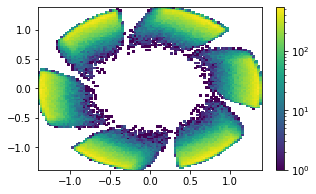

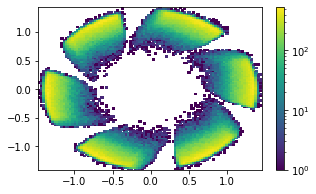

In [12]:

x = sampleDict["z"]
x = x.detach().numpy()

bin_size = [100,100]

fig, ax = plt.subplots(figsize =(5, 3)) 
plt.hist2d(x[:,0], x[:,1],bins =bin_size,norm=mpl.colors.LogNorm())# cmap = plt.cm.nipy_spectral) 
plt.colorbar()
print("next one")


x = sampleDict["x"]
x = x.detach().numpy()

bin_size = [100,100]

fig, ax = plt.subplots(figsize =(5, 3)) 
plt.hist2d(x[:,0], x[:,1],bins =bin_size,norm=mpl.colors.LogNorm())# cmap = plt.cm.nipy_spectral) 
plt.colorbar()
print("next one")

# xyz = xz.gs

# x = xyz.inverse_transform(x)

# fig, ax = plt.subplots(figsize =(5, 3)) 
# plt.hist2d(x[:,0], x[:,1],bins =bin_size,norm=mpl.colors.LogNorm())# cmap = plt.cm.nipy_spectral) 
# plt.colorbar()
# print("next one")


# data_train = x
# data_train_X = pd.DataFrame(gauss_scaler.transform(data_train))
# data_train_Z = data_train_X.to_numpy()
# test_transformed = gauss_scaler.inverse_transform(data_train_X.to_numpy())
# print(data_train)       

# test_transformed = gauss_scaler.inverse_transform(data_train_X.to_numpy())
# data_train.hist()

# x = data_train
# fig, ax = plt.subplots(figsize =(5, 3)) 
# plt.hist2d(x[:,0], x[:,1],bins =bin_size,norm=mpl.colors.LogNorm())# cmap = plt.cm.nipy_spectral) 
# plt.colorbar()
# print("next one")

# z = data_train_Z
# fig, ax = plt.subplots(figsize =(5, 3)) 
# plt.hist(z[:,0],bins=100) 
# fig, ax = plt.subplots(figsize =(5, 3)) 
# plt.hist(z[:,1],bins=100) 
# fig, ax = plt.subplots(figsize =(5, 3)) 
# plt.hist2d(z[:,0], z[:,1],bins =bin_size,norm=mpl.colors.LogNorm())# cmap = plt.cm.nipy_spectral) 
# plt.colorbar()
# print("next one")
# fig, ax = plt.subplots(figsize =(5, 3)) 
# plt.hist2d(z[:,2], z[:,3],bins =bin_size,norm=mpl.colors.LogNorm())# cmap = plt.cm.nipy_spectral) 
# plt.colorbar()



## Construct a model
We try with a 4d example, electron momentum magnitude and polar angle only. The prior can be any constant distributions, or the parent distributions of `z`. At this stage, we look into the proof of concept, starting with 2d constant distribution. We firstly use the logistic distribution, which can be inverse transform sampled from sigmoid distribution. We pick Adam as our optimizer.

In [13]:
num_features = 2

in_columns = num_features
out_columns = num_features

context_encoder = nn.Sequential(
          nn.Linear(num_features, 2*num_features),
          nn.ReLU(),
          nn.Linear(2*num_features, 2*num_features),
          nn.ReLU(),
          nn.Linear(2*num_features, 2*num_features)
        )

In [14]:

num_layers =6#12
#base_dist = StandardNormal(shape=[num_features]
base_dist = ConditionalDiagonalNormal(shape=[num_features],context_encoder=context_encoder)
#base_dist = DiagonalNormal(shape=[3])
transforms = []
for _ in range(num_layers):
    transforms.append(ReversePermutation(features=num_features))
    # transforms.append(MaskedAffineAutoregressiveTransform(features=num_features, 
    #                                                      hidden_features=100))
    transforms.append(MaskedAffineAutoregressiveTransform(features=num_features, 
                                                         hidden_features=100,
                                                          context_features=num_features))
    

    #transforms.append(MaskedUMNNAutoregressiveTransform(features=num_features, 
    #                                                      hidden_features=4))
transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist).to(device)
optimizer = optim.Adam(flow.parameters())
print("number of params: ", sum(p.numel() for p in flow.parameters()))

number of params:  252076


## Define some classes to visualize and evaluate the nflow models.
We plot the distribution of each feature in the same axis. We evalute the distribution in terms of how close they are. The closeness is quantified by some metrics like KL divergence, Wasserstein distance, and Jensen-Sahnnon divergence.

In [15]:
def plot_histo_1D(real_vals, gen_vals, label_real="Physics Data", label_gen="NFlow Model", col2 = "blue",title="Physics vs NFlow Models", saveloc=None):
    fig, axes = plt.subplots(1, 4, figsize=(4*5, 5))
    for INDEX, ax in zip((0, 1, 2,3 ), axes):
        _, bins, _ = ax.hist(real_vals[:, INDEX], bins=100, color = "red", label=label_real, density=True)
        ax.hist(gen_vals[:, INDEX], bins=bins, label=label_gen, color = col2,alpha=0.5, density=True)
        ax.legend(loc="lower left")
        ax.set_title("Feature {}".format(INDEX) )
    plt.tight_layout()
    if saveloc is not None: plt.savefig(saveloc)
    plt.show()

def meter(dist1,dist2,feature):
  kld = entropy(dist1[:,feature],dist2[:,feature])
  emd = wasserstein_distance(dist1[:,feature],dist2[:,feature])
  jsd = distance.jensenshannon(dist1[:,feature],dist2[:,feature]) ** 2
  return [kld, emd, jsd]

## Training step.

We have 1k training steps, each of which uses 1k random sample training data sets. We visualize the training loss and the metrics for the distributions.

In [16]:
num_iter = 1000
start_now = datetime.now()
start_time = start_now.strftime("%H:%M:%S")
print("Start Time =", start_time)
losses = []
f1_kd = []
f1_em = []
f1_js = []
f2_em = []
f3_em = []

for i in range(num_iter):
    # x, y = datasets.make_moons(12, noise=.1)
    # x = torch.tensor(x, dtype=torch.float32)
    # print(x)
    # print(y)
    sampleDict = xz.sample(1000)
    x_train = sampleDict["x"][:, 0:num_features].to(device)
    z_train = sampleDict["z"][:, 0:num_features].to(device)

    #print(xxx)
    #xx = sampleDict["xwithoutPid"].to(device)
    #data_train_X = pd.DataFrame(gauss_scaler.transform(xx))
    #data_train_Z = data_train_X.to_numpy()
    #xp =  data_train_Z[:, 0:num_features]
    x# = torch.from_numpy(xp)
    #print(x)
    #y = sampleDict["xwithoutPid"][:, 1:2] 
    #print(x)
    optimizer.zero_grad()
    loss = -flow.log_prob(inputs=x_train,context=z_train).mean()
    #loss = -flow.log_prob(inputs=xxx,context=xxx).mean()
    #print(loss)
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())

    if i %100 == 0:
        run_time = datetime.now()
        elapsedTime = (run_time - start_now )
        print("On step {} - loss {:.2f}, Current Running Time = {:.2f} seconds".format(i,loss.item(),elapsedTime.total_seconds())) 

    if i == 5000 == 0:
            run_time = datetime.now()
            elapsedTime = (run_time - start_now )
            
            bbb = 50000
            z= flow.sample(bbb).cpu().detach().numpy()
            sampleDict = xz.sample(bbb)
            x = sampleDict["x"][:, 0:num_features] 
            x = x.detach().numpy()

            #plot_histo_1D(x,z)

            f1 = meter(x,z,0)
            f2 = meter(x,z,1)
            #f3 = meter(x,z,2)
            #f4 = meter(x,z,3)

            bin_size = [100,100]
            fig, ax = plt.subplots(figsize =(10, 7)) 
            plt.rcParams["font.size"] = "16"
            ax.set_xlabel("Electron Momentum")  
            ax.set_ylabel("Proton Momentum")
            plt.title('NFlow Generated EP Distribution')

            plt.hist2d(z[:,0], z[:,1],bins =bin_size,norm=mpl.colors.LogNorm())# cmap = plt.cm.nipy_spectral) 
            #plt.xlim([-2,2])
            #plt.ylim([-2,2])
            plt.colorbar()
            plt.show()


            #if f1[1]*f2[1]*f3[1]*f4[1] < 1:
            print("On step {} - loss {:.2f}, Current Running Time = {:.2f} seconds".format(i,loss.item(),elapsedTime.total_seconds())) 
            #print("EM Distance   Values: F0: {:.5f}  F1: {:.5f}  F2: {:.5f} F3: {:.5f} ".format((f1[1]),(f2[1]),(f3[1]),(f4[1]),))
            print("EM Distance   Values: F0: {:.5f}  F1: {:.5f}  F2: {:.5f} F3: {:.5f} ".format((f1[1]),(f2[1]),(f2[1]),(f2[1]),))
            #if f1[1]*f2[1] < .001:
              #break

            f1_kd.append(f1[0])
            f1_em.append(f1[1])
            f1_js.append(f1[2])
            f2_em.append(f2[1])
            #f3_em.append(f3[1])
            #f4_em.append(f4[1])


now = datetime.now()
end_time = now.strftime("%H:%M:%S")
print("End Time =", end_time)
elapsedTime = (now - start_now )
print("Total Run Time = {:.5f} seconds".format(elapsedTime.total_seconds()))
    # if (i + 1) % 50 == 0:
    #     xline = torch.linspace(-1.5, 2.5)
    #     yline = torch.linspace(-.75, 1.25)
    #     xgrid, ygrid = torch.meshgrid(xline, yline)
    #     xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

    #     with torch.no_grad():
    #         zgrid = flow.log_prob(xyinput).exp().reshape(100, 100)

    #     plt.contourf(xgrid.numpy(), ygrid.numpy(), zgrid.numpy())
    #     plt.title('iteration {}'.format(i + 1))
    #     plt.show()

Start Time = 21:59:15
On step 0 - loss 5.89, Current Running Time = 0.24 seconds
On step 100 - loss -2.43, Current Running Time = 2.33 seconds
On step 200 - loss -4.17, Current Running Time = 4.35 seconds
On step 300 - loss -1.72, Current Running Time = 6.38 seconds
On step 400 - loss -5.34, Current Running Time = 8.41 seconds
On step 500 - loss -4.80, Current Running Time = 10.43 seconds
On step 600 - loss -5.53, Current Running Time = 12.46 seconds
On step 700 - loss -5.54, Current Running Time = 14.52 seconds
On step 800 - loss -5.69, Current Running Time = 16.56 seconds
On step 900 - loss -5.68, Current Running Time = 18.57 seconds
End Time = 21:59:36
Total Run Time = 20.56919 seconds


## Test step.
We evaluate our model by sampling new $\mathbf{x}$. We calculate the metrics between evaluation data set from NF and physics samples from that we have.

next one
next one


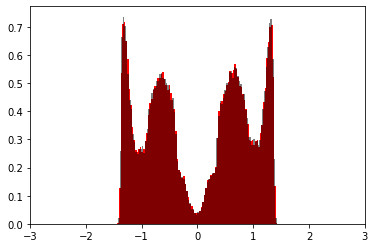

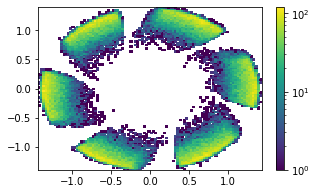

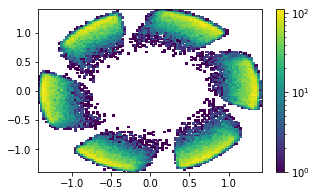

In [17]:
nsamp = 100000
sampleDict = xz.sample(nsamp) #Get a subset of the datapoints
x = sampleDict["x"]
x = x.detach().numpy()
z = sampleDict["z"]
z = z.detach().numpy()

context_val = torch.tensor(z, dtype=torch.float32).to(device)

val_gen = flow.sample(1,context=context_val).cpu().detach().numpy().reshape((nsamp,-1))


plt.hist(x[:,0],color = "red", density=True,bins=100)
plt.hist(val_gen[:,0],color = "black",alpha=0.5, density=True,bins=100)
plt.xlim([-3,3])


fig, ax = plt.subplots(figsize =(5, 3)) 
plt.hist2d(x[:,0], x[:,1],bins =bin_size,norm=mpl.colors.LogNorm())# cmap = plt.cm.nipy_spectral) 
plt.colorbar()
print("next one")

fig, ax = plt.subplots(figsize =(5, 3)) 
plt.hist2d(val_gen[:,0], val_gen[:,1],bins =bin_size,norm=mpl.colors.LogNorm())# cmap = plt.cm.nipy_spectral) 
plt.colorbar()
print("next one")

